In [1]:
import tensorflow as tf

In [9]:
items = ['Alaxan', 'Bactidol', 'Bioflu', 'Biogesic', 'DayZinc', 'Decolgen', 'Fish Oil', 'Kremil S', 'Medicol', 'Neozep']

In [11]:
args = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names": items
}

In [12]:
# Mount Google Drive (if your images are stored there)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set the path to your image directory
images = "/content/drive/My Drive/images2/"

Mounted at /content/drive


##Image Loading
Loads the images from directory and converts it into a tensorflow dataset.


> keras: High level ML library

In [13]:
train = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/My Drive/images2",
    subset="training",
    **args
)

test = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/My Drive/images2",
  subset="validation",
    **args
)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.
Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


In [14]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

##Exploring Tensorflow images

Takes the first 32 images i.e., the first batch

In [15]:
first = train.take(1)
first

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [16]:
images, labels = list(first)[0]
first_image = images[0]

In [17]:
first_image[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[11.828125 , 10.65625  ,  9.521301 ],
       [10.420593 ,  9.484375 ,  8.7421875],
       [ 8.5703125,  8.3125   ,  7.754944 ]], dtype=float32)>

##Displaying Images
Printing the image as a picture

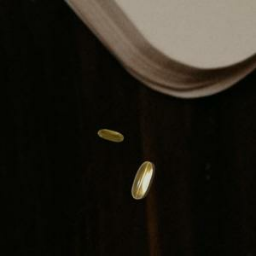

In [18]:
from PIL import Image

Image.fromarray(images[0].numpy().astype("uint8"))

In [19]:
print(labels[0])

tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


#Training Initial Convolutional Layer


*   cache: store the images in buffer instead of loading multiple times
*   prefetch: prefetches images from disk into memory



In [20]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

##Creating a Sequential Model


*   Rescale to 0-1
*   Convolutional layer to extract features
*   Flatten the layers i.e., converts the output from several different matrices to 1 matrix
*    Converts ouput of a CNN to a normal NN i.e., to make a prediction



In [21]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  #16 filters to extract features
  #3 x 3 pixel scanning at a  time
  #Activation Function should be specified
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256,256,3)),
  #Flatten the layers i.e., converts the output from several different matrices to 1 matrix
  layers.Flatten(),
  #Converts ouput of a CNN to a normal NN i.e., to a prediction
  layers.Dense(128, activation='relu'),
  #Layer that actually makes the prediction
  layers.Dense(len(items))
])

##Compile the model
*  Optimizer: How to predict error and how to iterate as it goes through multiple runs
*  Loss Function: Error is calculated and minimize it


In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
history = model.fit(
    train,
    validation_data=test,
    epochs=5,
    verbose=1
)

Epoch 1/5
250/250 [==============================] - 1644s 7s/step - loss: 13.6451 - accuracy: 0.1045 - val_loss: 2.3044 - val_accuracy: 0.0995
Epoch 2/5
250/250 [==============================] - 16s 62ms/step - loss: 2.3023 - accuracy: 0.1066 - val_loss: 2.3006 - val_accuracy: 0.1025
Epoch 3/5
250/250 [==============================] - 15s 61ms/step - loss: 2.2963 - accuracy: 0.1050 - val_loss: 2.2953 - val_accuracy: 0.1050
Epoch 4/5
250/250 [==============================] - 15s 61ms/step - loss: 2.2919 - accuracy: 0.1058 - val_loss: 2.2962 - val_accuracy: 0.1010
Epoch 5/5
250/250 [==============================] - 16s 62ms/step - loss: 2.2882 - accuracy: 0.1045 - val_loss: 2.2921 - val_accuracy: 0.1040


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 134219594 (512.01 MB)
Trainable params: 134219594 (512.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

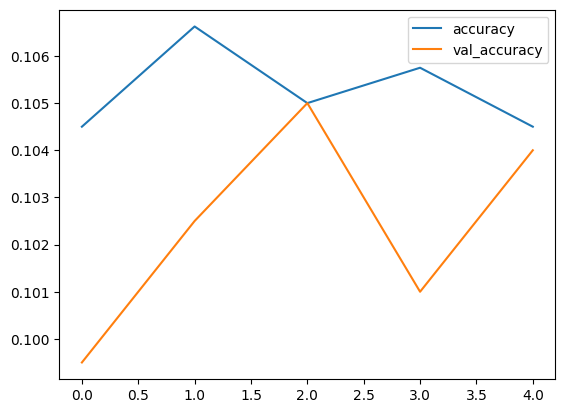

In [25]:
import pandas as pd

history_df = pd.DataFrame.from_dict(history.history)
history_df[["accuracy", "val_accuracy"]].plot()

In [26]:
def train_model(network, epochs=5):
    model = Sequential(network)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(
      train,
      validation_data=test,
      epochs=epochs
    )
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df, model

In [27]:
network = [
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 4, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(items))
]

history_df, model = train_model(network)

Epoch 1/5
250/250 [==============================] - 22s 68ms/step - loss: 2.2674 - accuracy: 0.1536 - val_loss: 2.0903 - val_accuracy: 0.1795
Epoch 2/5
250/250 [==============================] - 16s 66ms/step - loss: 1.8970 - accuracy: 0.2759 - val_loss: 1.8234 - val_accuracy: 0.2990
Epoch 3/5
250/250 [==============================] - 17s 67ms/step - loss: 1.5345 - accuracy: 0.4218 - val_loss: 1.6288 - val_accuracy: 0.3940
Epoch 4/5
250/250 [==============================] - 17s 66ms/step - loss: 1.1547 - accuracy: 0.5725 - val_loss: 1.6374 - val_accuracy: 0.4400
Epoch 5/5
250/250 [==============================] - 16s 66ms/step - loss: 0.8115 - accuracy: 0.6988 - val_loss: 1.6219 - val_accuracy: 0.4740


<Axes: >

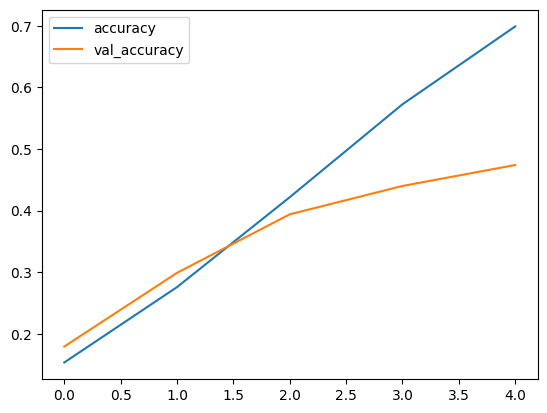

In [28]:
history_df[["accuracy", "val_accuracy"]].plot()

In [29]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", seed=1),
      layers.RandomRotation(0.2, seed=1),
    layers.RandomZoom(0.2, seed=1),
  ]
)


full_network = [
    data_augmentation
] + network

history_df, model = train_model(full_network, epochs=10)

Epoch 1/10
250/250 [==============================] - 20s 69ms/step - loss: 1.2113 - accuracy: 0.5583 - val_loss: 1.0254 - val_accuracy: 0.6180
Epoch 2/10
250/250 [==============================] - 17s 69ms/step - loss: 0.9610 - accuracy: 0.6528 - val_loss: 0.8569 - val_accuracy: 0.7215
Epoch 3/10
250/250 [==============================] - 17s 69ms/step - loss: 0.7430 - accuracy: 0.7480 - val_loss: 0.6890 - val_accuracy: 0.7815
Epoch 4/10
250/250 [==============================] - 17s 69ms/step - loss: 0.5875 - accuracy: 0.8099 - val_loss: 0.6273 - val_accuracy: 0.7945
Epoch 5/10
250/250 [==============================] - 17s 69ms/step - loss: 0.4929 - accuracy: 0.8380 - val_loss: 0.4455 - val_accuracy: 0.8690
Epoch 6/10
250/250 [==============================] - 17s 69ms/step - loss: 0.4191 - accuracy: 0.8687 - val_loss: 0.4168 - val_accuracy: 0.8740
Epoch 7/10
250/250 [==============================] - 17s 70ms/step - loss: 0.3599 - accuracy: 0.8885 - val_loss: 0.3579 - val_accuracy:

<Axes: >

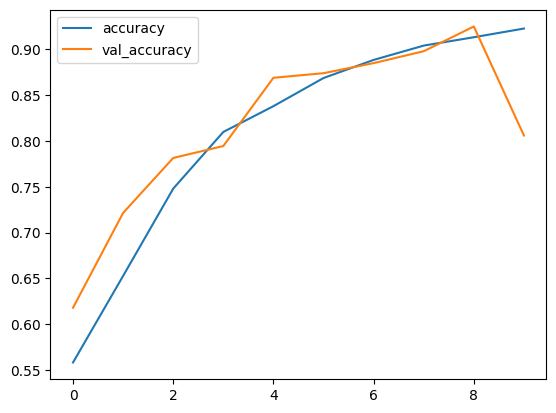

In [30]:
history_df[["accuracy", "val_accuracy"]].plot()

In [31]:
preds = model.predict(test)

63/63 [==============================] - 1s 17ms/step


In [32]:
import numpy as np
predicted_class = np.argmax(preds, axis=1)

In [33]:
actual_labels = np.concatenate([y for x, y in test], axis=0)

In [34]:
import itertools

actual_image = [x.numpy().astype("uint8") for x, y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

In [35]:
actual_class = np.argmax(actual_labels, axis=1)

In [36]:
pred_df = pd.DataFrame(zip(predicted_class, actual_class, actual_image), columns=["prediction", "actual", "image"])

In [37]:
pred_df["prediction"] = pred_df["prediction"].apply(lambda x: items[x])
pred_df["actual"] = pred_df["actual"].apply(lambda x: items[x])


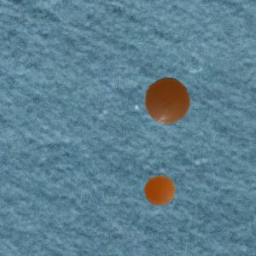
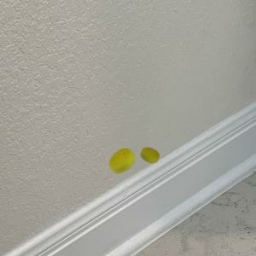
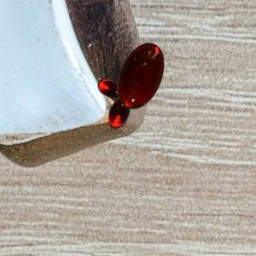
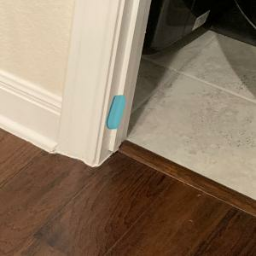
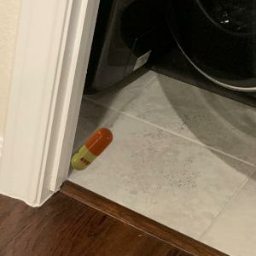
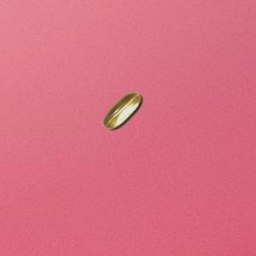
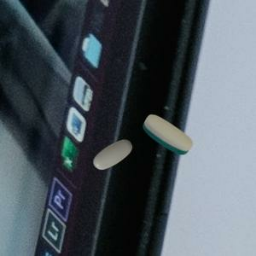
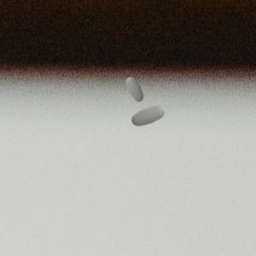
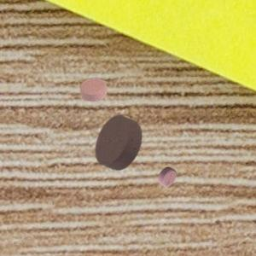
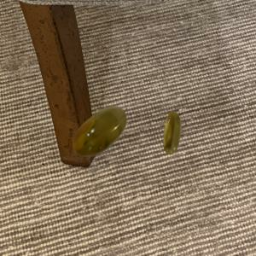
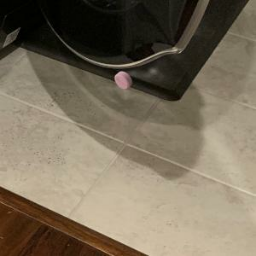
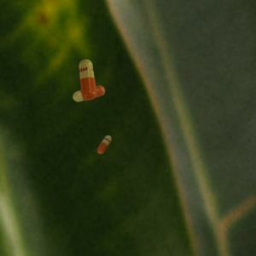
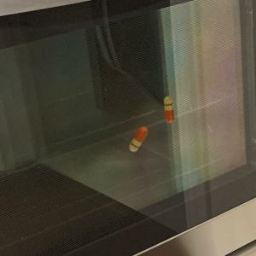
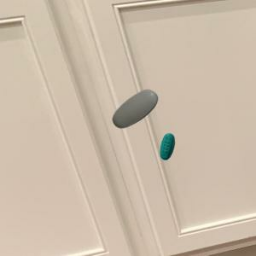
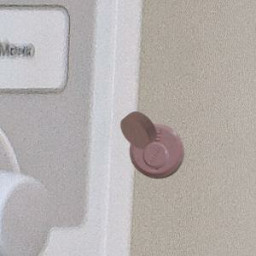
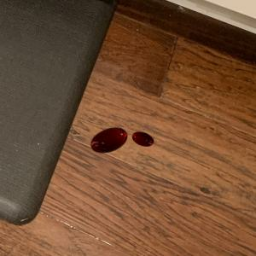
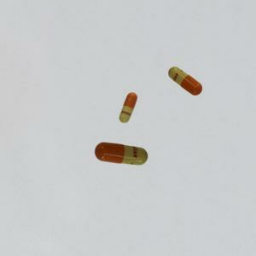
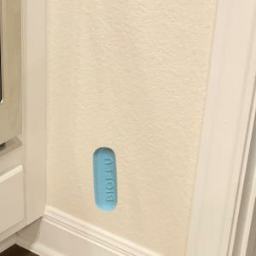
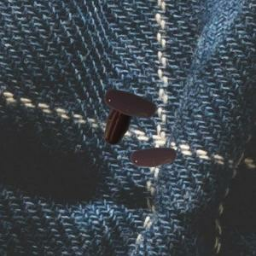
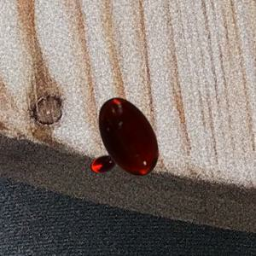
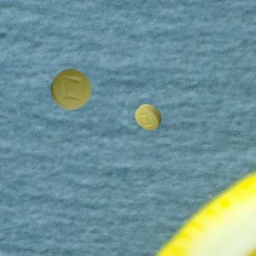
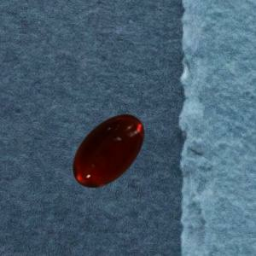
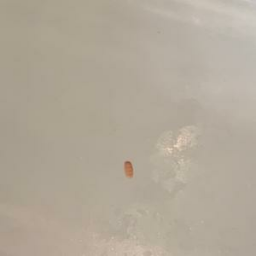
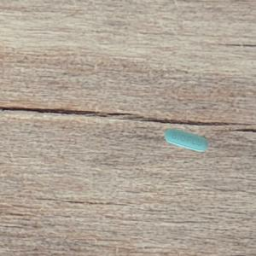
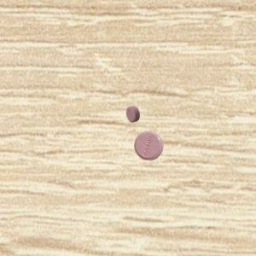
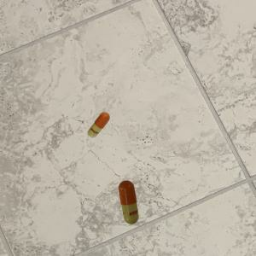
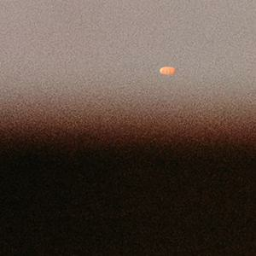
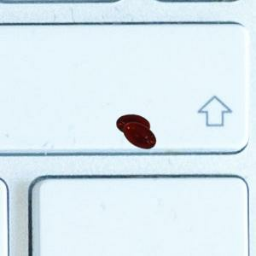
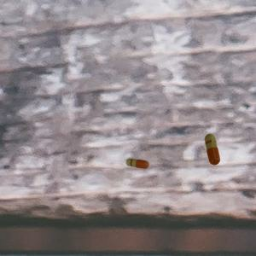
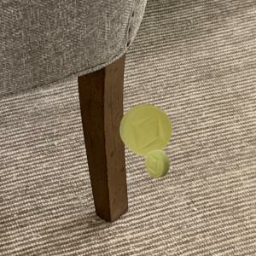
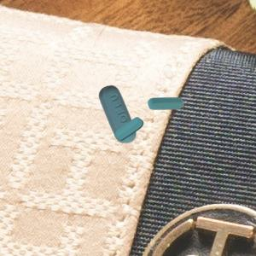
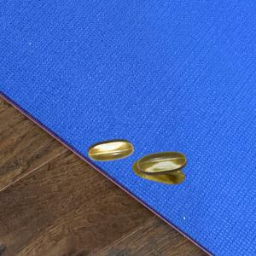
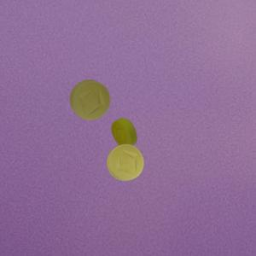
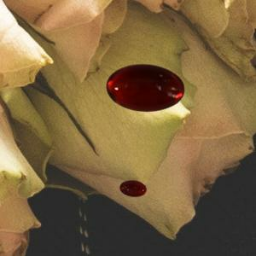
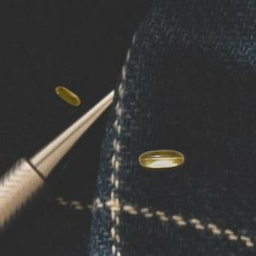
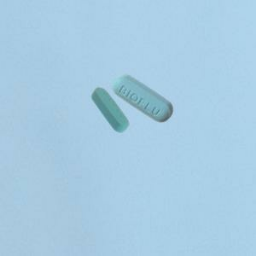
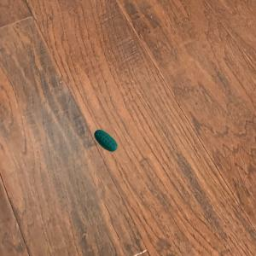
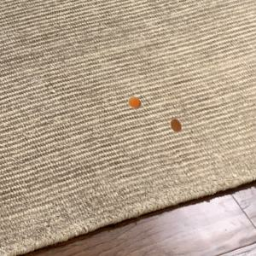
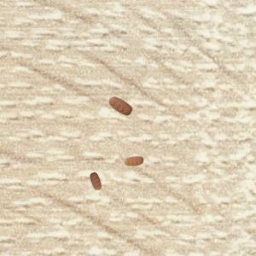
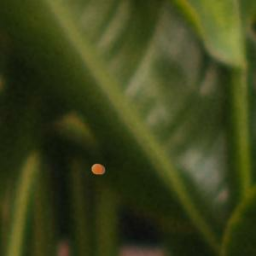
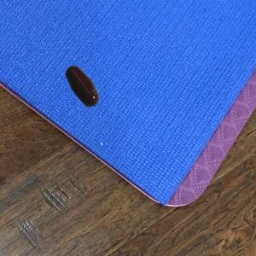
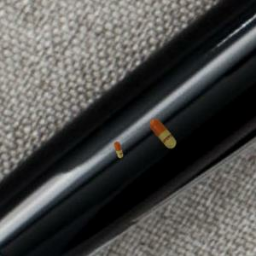
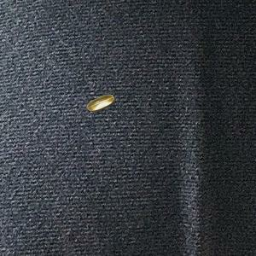
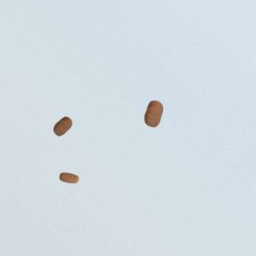
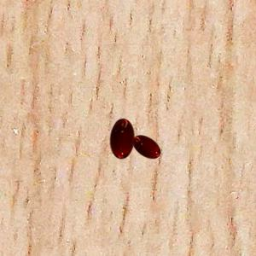
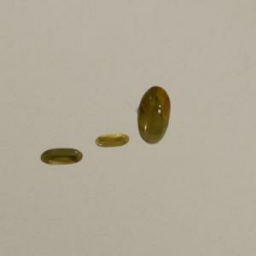
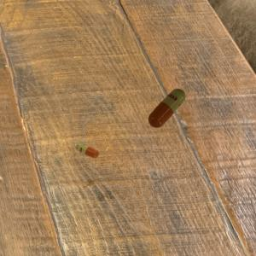
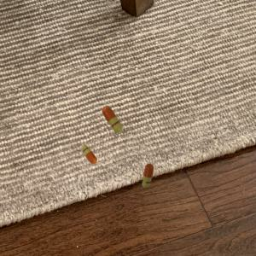
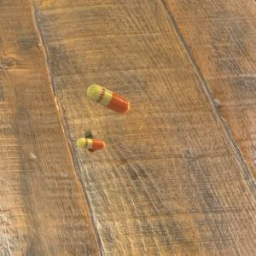
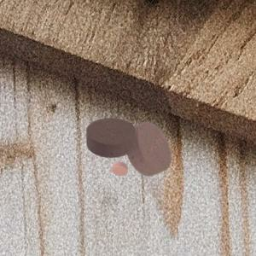
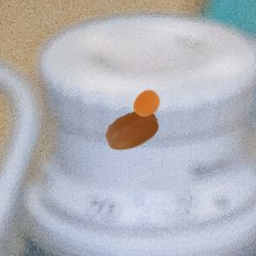
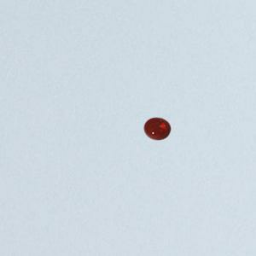
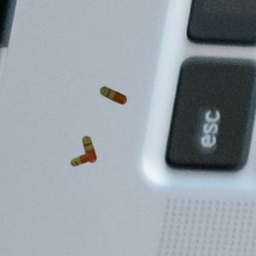
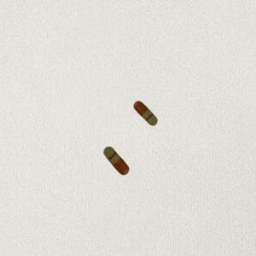
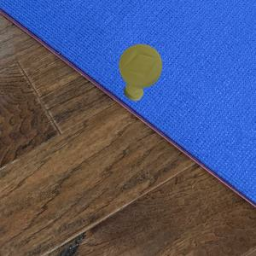
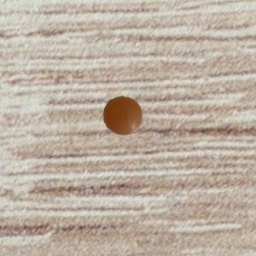
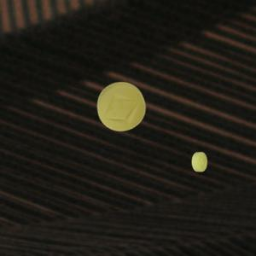
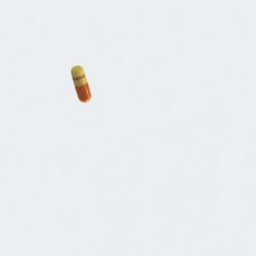
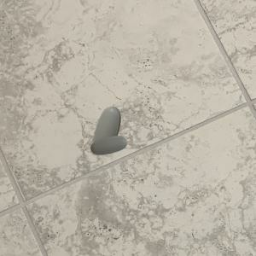
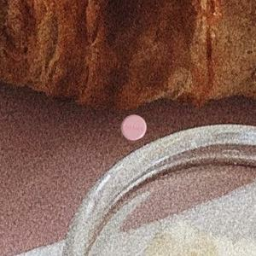
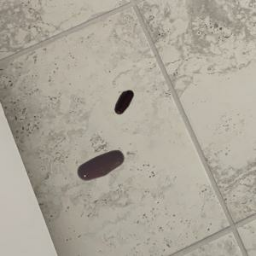
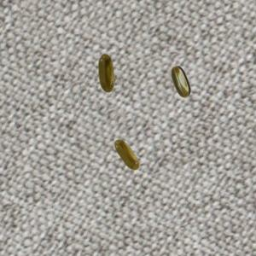
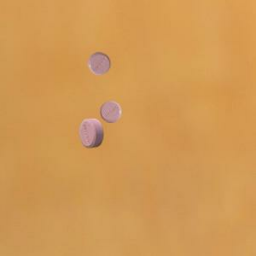
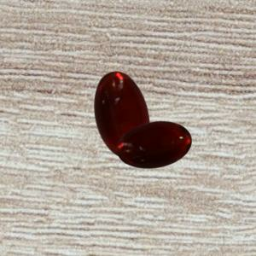
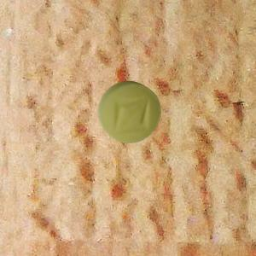
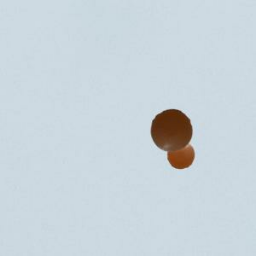
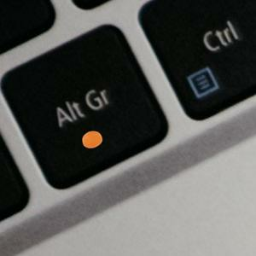
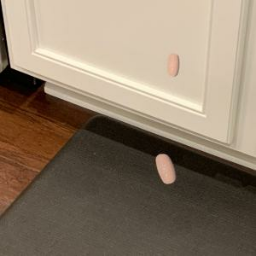
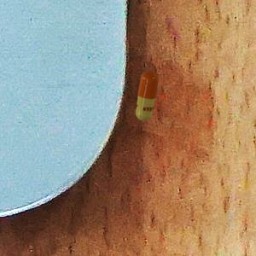
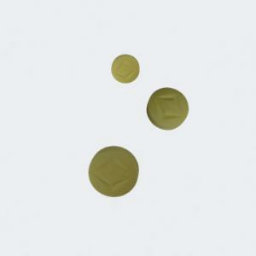
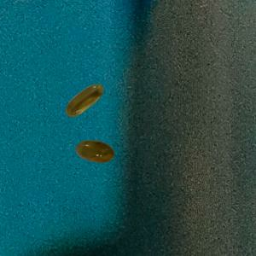
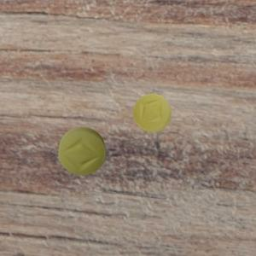
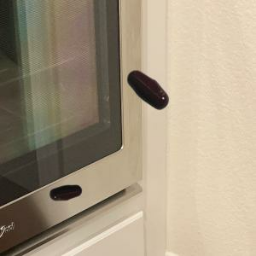
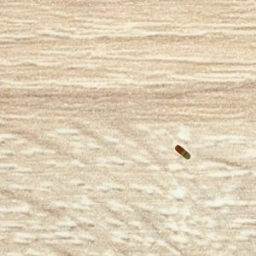
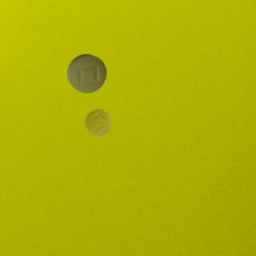
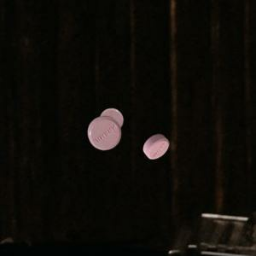
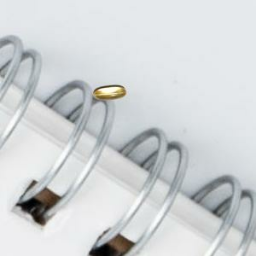
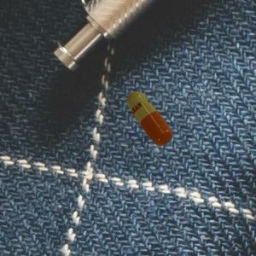
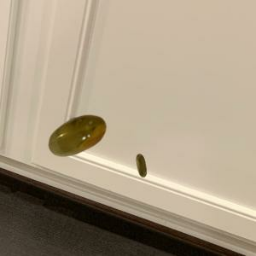
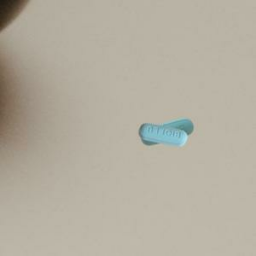
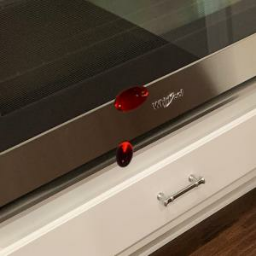
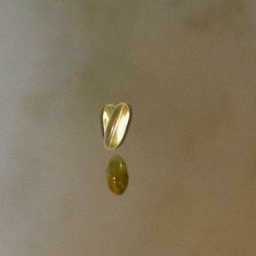
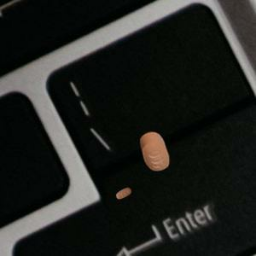
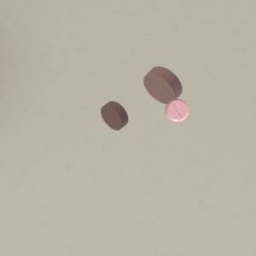
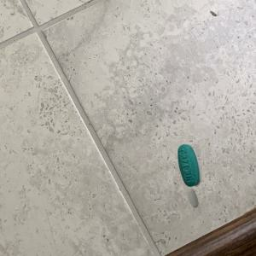
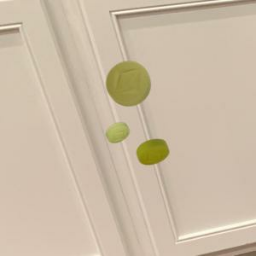
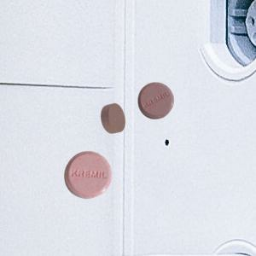
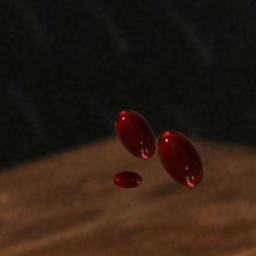
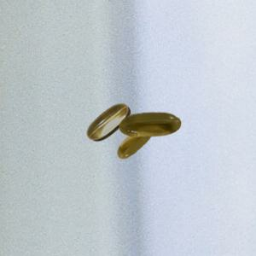
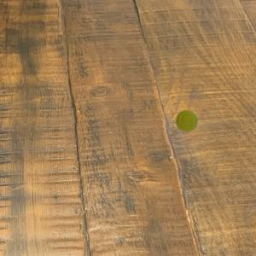
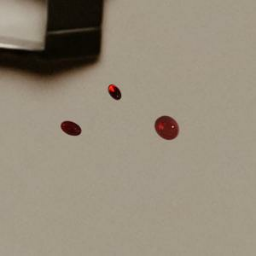
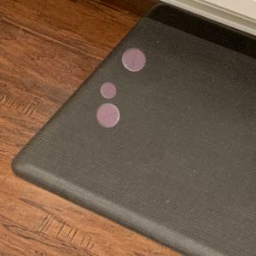
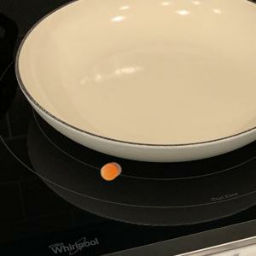
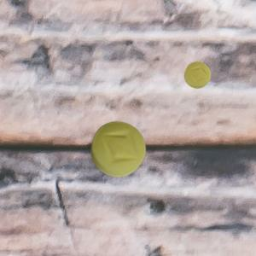
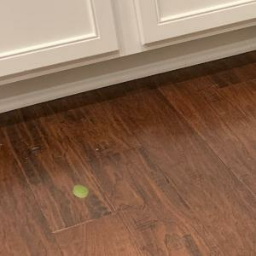
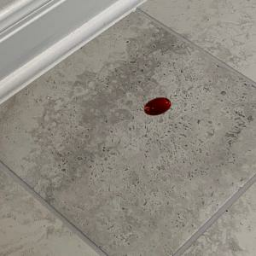
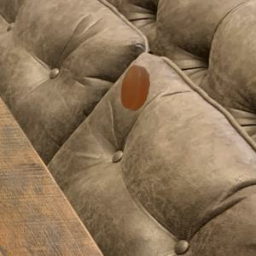
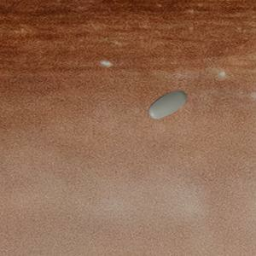
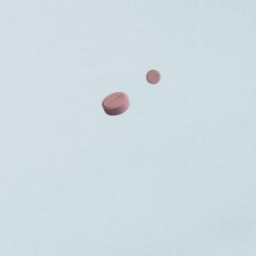
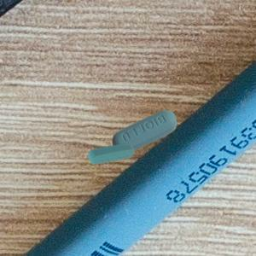

In [41]:
import base64
import io

def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'

pred_df.head(100).style.format({'image': image_formatter})

In [39]:
from sklearn.metrics import accuracy_score

# Convert predicted and actual classes to lists
predicted_classes = pred_df["prediction"].tolist()
actual_classes = pred_df["actual"].tolist()

# Calculate accuracy
accuracy = accuracy_score(actual_classes, predicted_classes)

print("Accuracy:", accuracy)

Accuracy: 0.806
